# Example 1

## Problem

$$Min \int_0^{t_f}x\sqrt{1+u^2}dt\\
\dot{x} = u\\
u\in\R$$

In [140]:
# Packages

using Pkg
Pkg.activate(".")
#
using OptimalControl
using LinearAlgebra
using ForwardDiff
using DifferentialEquations

using MINPACK # NLE solver
using NLsolve
using LaTeXStrings

  Activating project at `~/control-toolbox/indirect`


## Control-toolbox definition of the problem

In [141]:
t0 = 0
tf = 2
x0 = 1
xf = 1
@def ocp begin
    t ∈ [ t0, tf ], time
    x ∈ R, state
    u ∈ R, control
    x(t0) == x0
    x(tf) == xf
    #ẋ₁(t) == x₂(t)
    #ẋ₂(t) == u(t)
    ẋ(t) ==  u(t)
    ∫(x(t)*(1 + u(t)^2)^(1/2)) → min
end


┌───────┬───────┬─────────┬──────────┬───────────┬─────────────┐
│ times │ state │ control │ dynamics │ objective │ constraints │
├───────┼───────┼─────────┼──────────┼───────────┼─────────────┤
│    ✅ │    ✅ │      ✅ │       ✅ │        ✅ │          ✅ │
└───────┴───────┴─────────┴──────────┴───────────┴─────────────┘


t ∈ [t0, tf], time
x ∈ R, state
u ∈ R, control
x(t0) == x0
x(tf) == xf
ẋ(t) == u(t)
∫(x(t) * (1 + u(t) ^ 2) ^ (1 / 2)) → min


Int_p_0 = fill(-0.99)


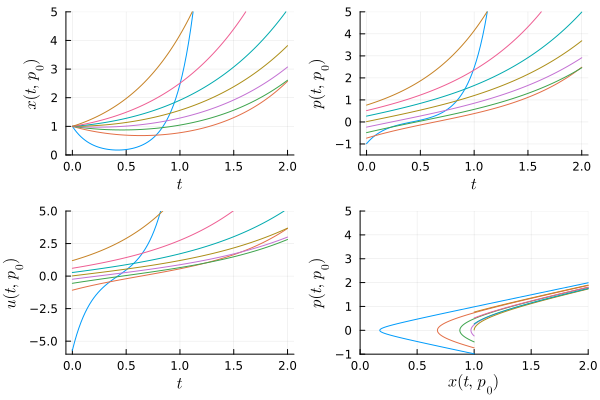

In [142]:
# Compute the  Flow

# 
#ε = 1.e-14
#ε = 0.   # there is no derivative of sqrt() in 0
#u(x, p) = sign(x[1])*sign(p[1])*sqrt((p[1]^2+ε)/(x[1]^2-p[1]^2))  # contol function
u(x, p) = sign(x[1])*p[1]*sqrt(1. /(x[1]^2-p[1]^2))  # contol function

ocp_flow = Flow(ocp, u)   # f is the hamiltonian flow

Int_p0 = -0.985:0.25:0.98
println("Int_p_0 = ", collect(Int_p_0))
Δt = (tf - t0)/100
plt_x = plot()          # the state
plt_p = plot()          # the costate
plt_u = plot()          # the control
plt_phase = plot()     #

for p0 in Int_p0 # Int_p0[1:1]
    flow_p0 = ocp_flow((t0, tf), x0, p0, reltol = 1e-8, abstol = 1e-8, saveat = Δt)
    T = flow_p0.ode_sol.t
    X = flow_p0.ode_sol[1,:]
    P = flow_p0.ode_sol[2,:]
    par = atanh(p0./x0)
    plot!(plt_x,T,X)
    plot!(plt_p,T,P)
    plot!(plt_u,T,u.(X,P))  
    plot!(plt_phase,X,P)      
    #plot!(plt,flow_p0, control_style=(label="u for p_0",)) # pb car pas les même ordonnées
end

#flow_sol = f((t0, tf), x0, p_sol, saveat = Δt)    

#plot!(plt, flow_sol, control_style=(label="u_sol",))

#plot!(plt[5], ylims=(-6, 6))
plot!(plt_x,xlabel = L"t",ylabel=L"x(t,p_0)",legend=false, ylims=(0.,5.))
plot!(plt_p,xlabel = L"t",ylabel=L"p(t,p_0)",legend=false, ylims=(-1.5,5.))
plot!(plt_u,xlabel = L"t",ylabel=L"u(t,p_0)",legend=false, ylims=(-6.,5.))
plot!(plt_phase,xlabel = L"x(t,p_0)",ylabel=L"p(t,p_0)",legend=false, xlims=(0.,2.), ylims=(-1.,5.))
plot(plt_x,plt_p,plt_u,plt_phase,layout = (2,2))

In [153]:

#
# Conjugate points
#
function x(t,x₀,p0)
    λ = atanh(p0/x₀)
    β = x₀/cosh(λ)
    α = -λ*β
    return β*cosh((t-α)/β)
end
"""
   costate
"""
function p(t,x₀,p0)
    λ = atanh(p0/x₀)
    β = x₀/cosh(λ)
    α = -λ*β
    return β*sinh((t-α)/β)
end

function jacobi_ana(δz, par, t)
    x0, p0 = par   # (x_0,p_0)

    x_t = x(t,x0,p0)
    p_t = p(t,x0,p0)
    temp = 1/(x_t^2 - p_t^2)^(3/2)
    return temp*[-x_t*p_t x_t^2 ; -p_t^2 x_t*p_t]*δz
end

function flow_jacobi_ana(t0tf,x0,p0)

    t0, tf = t0tf
    prob = ODEProblem(jacobi_ana,[0;1],t0tf,[x0;p0])
    sol = DifferentialEquations.solve(prob,reltol = 1e-8, abstol = 1e-8) #DifferentialEquations.
    return sol
end

p0 = -0.9
println("x0 = ", x0)
println("p0 = ", p0)
sol_ana = flow_jacobi_ana((0,tf),x0,p0)
Δt = 1.
t0, tf = t0tf
for t in t0:Δt:tf
    println(sol_ana(t))
end

function flow_jacobi(t0tf,x0,p0)
    Δt = 1.
    t0, tf = t0tf
    Int_t0tf = t0:Δt:tf
    sol = zeros(length(Int_t0tf)) 
    for t in Int_t0tf
        flow_p0(p_0) = ocp_flow((t0, tf), x0, p_0, reltol = 1e-8, abstol = 1e-8, saveat = Δt)(t)
        temp = ForwardDiff.derivative(flow_p0, p0)
        println(temp)
        println(size(temp))
        n=1
        sol[] = det(temp[1:n,1:n])
        #sol = det(temp[])
    end
    return sol
end

println(flow_jacobi((t0,tf),x0,p0))


#plot!(plt4_ana,xlabel = L"t",ylabel=L"\delta x(t,p_0)",legend=false, ylims=(-10.,10.))
#plot(plt4_ana)

x0 = 1
p0 = -0.9


[0.0, 1.0]
[0.5607927646156636, -1.420577171038611]
[-57.48507667781572, -57.89487446109293]


[0.0, 1.0]
(2,)


det = 0.0
[0.5607927655712404, -1.4205771710845685]
(2,)
det = 0.5607927655712404
[-57.48507673211562, -57.89487451551244]
(2,)
det = -57.48507673211562
nothing


In [139]:

# Define the shooting function
#S(p0) = f(t0, x0, p0, tf)[1] - xf;

#println(S([0. ; 0.]))
#println(S([12. ; 6.]))

##println(S([1. ; 1.]))

# solve the shooting equation
#nl_sol = nlsolve(S, [0.,0.],autodiff = :forward)

# ajouter une fonction qui renvoie une solution du pr de control de type OptimalControl_solution afin de faire le plot

#println("nl_sol = ", nl_sol)
#p_sol = nl_sol.zero
#println("p_sol = ", p_sol)

# draw the solution
#plot(f((t0, tf), x0, p_sol, saveat=[]).ode_sol)

# compute the solution: state, costate, control...
# if we don't have the saveat  option, then we obtain too few points from the numerical solution to have  a nice plot